In [1]:
import json
import warnings
from typing import Any, Literal

import numpy as np
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "white": "#FFFFFF",  # Bright white
        "info": "#00FF00",  # Bright green
        "warning": "#FFD700",  # Bright gold
        "error": "#FF1493",  # Deep pink
        "success": "#00FFFF",  # Cyan
        "highlight": "#FF4500",  # Orange-red
    }
)
console = Console(theme=custom_theme)

# Visualization
# import matplotlib.pyplot as plt

# NumPy settings
np.set_printoptions(precision=4)

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# Polars settings
pl.Config.set_fmt_str_lengths(1_000)
pl.Config.set_tbl_cols(n=1_000)
pl.Config.set_tbl_rows(n=200)

warnings.filterwarnings("ignore")

# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

In [2]:
def go_up_from_current_directory(*, go_up: int = 1) -> None:
    """This is used to up a number of directories.

    Params:
    -------
    go_up: int, default=1
        This indicates the number of times to go back up from the current directory.

    Returns:
    --------
    None
    """
    import os
    import sys

    CONST: str = "../"
    NUM: str = CONST * go_up

    # Goto the previous directory
    prev_directory = os.path.join(os.path.dirname(__name__), NUM)
    # Get the 'absolute path' of the previous directory
    abs_path_prev_directory = os.path.abspath(prev_directory)

    # Add the path to the System paths
    sys.path.insert(0, abs_path_prev_directory)
    print(abs_path_prev_directory)


# Demo (Prevents ruff from removing the unused module import)
name: Any
category: Literal["A", "B", "C"]
json.loads('{"name": "Smart-RAG", "version": "1.0"}')

{'name': 'Smart-RAG', 'version': '1.0'}

In [3]:
go_up_from_current_directory(go_up=1)

from src.config import app_settings  # noqa: E402
from src.utilities.model_config import RemoteModel  # noqa: E402

settings = app_settings

/Users/mac/Desktop/Projects/smart-rag


In [4]:
from langchain_openai import ChatOpenAI

remote_llm = ChatOpenAI(
    api_key=settings.OPENROUTER_API_KEY.get_secret_value(),  # type: ignore
    base_url=settings.OPENROUTER_URL,
    temperature=0.0,
    model=RemoteModel.GEMINI_2_0_FLASH_001,
)


# Test the LLMs
response = remote_llm.invoke("Tell me a very short joke.")
response.pretty_print()

================================== Ai Message ==================================

Why don't scientists trust atoms?

Because they make up everything!


In [5]:
from langchain.tools import tool

#### Create Tools

In [6]:
from langchain_tavily import TavilySearch

tavily_search = TavilySearch(
    api_key=settings.TAVILY_API_KEY.get_secret_value(),
    max_results=2,
    topic="general",
)
search_response = tavily_search.invoke({"query": "What is agentic RAG?"})

In [7]:
search_response["results"][0]["content"]

'* Agentic RAG # Agentic RAG Agentic RAG is a standard RAG implementation that uses AI agents to solve complex problems by extending the capabilities of LLMs. A classical RAG approach relies solely on LLMs. The agentic RAG method converts LLMs into AI agents and empowers them to use tools, functions, and external knowledge sources. * A RAG agent customer support system can help users find specific information from unstructured, semi-unstructured, and structured data formats. * Agent-powered RAG systems are excellent at looking at and retrieving information from heterogeneous enterprise data. In contrast, an agentic RAG system is capable of retrieving and synthesizing information from multiple sources and documents. A classic RAG can retrieve information from a single source, while an agentic RAG uses multiple agents to access and orchestrate data from diverse sources.'

In [8]:
search_response

{'query': 'What is agentic RAG?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://getstream.io/glossary/agentic-rag/',
   'title': 'Agentic RAG - What is it and how does it work? - GetStream.io',
   'content': '* Agentic RAG # Agentic RAG Agentic RAG is a standard RAG implementation that uses AI agents to solve complex problems by extending the capabilities of LLMs. A classical RAG approach relies solely on LLMs. The agentic RAG method converts LLMs into AI agents and empowers them to use tools, functions, and external knowledge sources. * A RAG agent customer support system can help users find specific information from unstructured, semi-unstructured, and structured data formats. * Agent-powered RAG systems are excellent at looking at and retrieving information from heterogeneous enterprise data. In contrast, an agentic RAG system is capable of retrieving and synthesizing information from multiple sources and documents. A classic RAG can ret

In [16]:
from datetime import datetime


@tool(response_format="content_and_artifact")
async def search_tool(query: str, max_chars: int = 500) -> tuple[str, dict]:
    """Perform a search using TavilySearch tool.

    Parameters:
    -----------
    query: str
        The search query.
    max_chars: int, default=1000
        The maximum number of characters per source to return from the search results.

    Returns:
    --------
    str
        The formatted search results.
    """
    separator: str = "\n\n"

    tavily_search = TavilySearch(
        api_key=settings.TAVILY_API_KEY.get_secret_value(),
        max_results=3,
        topic="general",
    )
    search_response = await tavily_search.ainvoke({"query": query})
    formatted_results: str = "\n\n".join(
        f"Title: {result['title']}\nContent: {result['content'][:max_chars]} [truncated]\nURL: {result['url']}{separator}"
        for result in search_response["results"]
    )
    return formatted_results, search_response


@tool(response_format="content")
def date_tool() -> str:
    """Get the current date in YYYY-MM-DD format.

    Returns:
    --------
    str
        The current date as a string.
    """

    return datetime.now().isoformat(timespec="seconds")

In [10]:
console.print(search_tool)

StructuredTool(
    name='search_tool',
    description='Perform a search using TavilySearch tool.\n\n    Parameters:\n    -----------\n    query: str\n   
The search query.\n    max_chars: int, default=1000\n        The maximum number of characters per source to return 
from the search results.\n\n    Returns:\n    --------\n    str\n        The formatted search results.',
    args_schema=<class 'langchain_core.utils.pydantic.search_tool'>,
    response_format='content_and_artifact',
    coroutine=<function search_tool at 0x13c792f20>
)

In [11]:
formatted_results, search_response = await search_tool.coroutine("what is agentic RAG?")
console.print(formatted_results)

Title: Agentic RAG - What is it and how does it work? - GetStream.io
Content: * Agentic RAG # Agentic RAG Agentic RAG is a standard RAG implementation that uses AI agents to solve 
complex problems by extending the capabilities of LLMs. A classical RAG approach relies solely on LLMs. The agentic
RAG method converts LLMs into AI agents and empowers them to use tools, functions, and external knowledge sources. 
* A RAG agent customer support system can help users find specific information from unstructured, 
semi-unstructured, and structured data formats. * Agent-powered RAG s 
URL: https://getstream.io/glossary/agentic-rag/



Title: What is Agentic RAG? | IBM
Content: # What is agentic RAG? Agentic RAG is the use of AI agents to facilitate retrieval augmented generation 
(RAG). Agentic RAG systems add AI agents to the RAG pipeline to increase adaptability and accuracy. ### What is 
agentic AI? AI agents ### What are AI agents? From monolithic models to compound AI systems, discover how AI agents
integrate with databases and external tools to enhance problem-solving capabilities and adaptability. ## How does 
agentic RAG work? Agentic RAG works by incorporating o 
URL: https://www.ibm.com/think/topics/agentic-rag



Title: Agentic RAG: How It Works, Use Cases, Comparison With RAG
Content: Learn about Agentic RAG, an AI paradigm combining agentic AI and RAG for autonomous information access and
generation. Agentic RAG combines agentic AI’s decision-making with RAG’s ability to pull in dynamic data. By 
continuously analyzing the context and user intent, agentic RAG systems can autonomously retrieve and integrate 
relevant information from diverse sources, including real-time data streams and external APIs. This proactive 
approach enables them to generate comprehensive and contextual 
URL: https://www.datacamp.com/blog/agentic-rag

In [12]:
console.print(search_response)

{
    'query': 'what is agentic RAG?',
    'follow_up_questions': None,
    'answer': None,
    'images': [],
    'results': [
        {
            'url': 'https://getstream.io/glossary/agentic-rag/',
            'title': 'Agentic RAG - What is it and how does it work? - GetStream.io',
            'content': '* Agentic RAG # Agentic RAG Agentic RAG is a standard RAG implementation that uses AI 
agents to solve complex problems by extending the capabilities of LLMs. A classical RAG approach relies solely on 
LLMs. The agentic RAG method converts LLMs into AI agents and empowers them to use tools, functions, and external 
knowledge sources. * A RAG agent customer support system can help users find specific information from 
unstructured, semi-unstructured, and structured data formats. * Agent-powered RAG systems are excellent at looking 
at and retrieving information from heterogeneous enterprise data. In contrast, an agentic RAG system is capable of 
retrieving and synthesizing information from multiple sources and documents. A classic RAG can retrieve information
from a single source, while an agentic RAG uses multiple agents to access and orchestrate data from diverse 
sources.',
            'score': 0.9451216,
            'raw_content': None
        },
        {
            'url': 'https://www.ibm.com/think/topics/agentic-rag',
            'title': 'What is Agentic RAG? | IBM',
            'content': '# What is agentic RAG? Agentic RAG is the use of AI agents to facilitate retrieval 
augmented generation (RAG). Agentic RAG systems add AI agents to the RAG pipeline to increase adaptability and 
accuracy. ### What is agentic AI? AI agents ### What are AI agents? From monolithic models to compound AI systems, 
discover how AI agents integrate with databases and external tools to enhance problem-solving capabilities and 
adaptability. ## How does agentic RAG work? Agentic RAG works by incorporating one or more types of AI agents into 
RAG systems. Agentic RAG systems can contain one or more types of AI agents, such as: Report   Agentic AI products 
to watch out for in 2025  AI agents for business    IBM AI agent solutions    Explore AI agent solutions   ',
            'score': 0.9393874,
            'raw_content': None
        },
        {
            'url': 'https://www.datacamp.com/blog/agentic-rag',
            'title': 'Agentic RAG: How It Works, Use Cases, Comparison With RAG',
            'content': 'Learn about Agentic RAG, an AI paradigm combining agentic AI and RAG for autonomous 
information access and generation. Agentic RAG combines agentic AI’s decision-making with RAG’s ability to pull in 
dynamic data. By continuously analyzing the context and user intent, agentic RAG systems can autonomously retrieve 
and integrate relevant information from diverse sources, including real-time data streams and external APIs. This 
proactive approach enables them to generate comprehensive and contextually relevant responses without requiring 
explicit human intervention. Agentic RAG combines the autonomy of agentic systems with the dynamic data retrieval 
of RAG. Learn how to use n8n to build AI agents that automate email processing and create a retrieval-augmented 
generation (RAG) agent for document question answering.',
            'score': 0.9197076,
            'raw_content': None
        }
    ],
    'response_time': 0.82,
    'request_id': '6248433c-8358-4c24-9459-934bb024bcd4'
}

In [18]:
date_tool.func()

# console.print(date_tool)

'2025-10-26T02:57:40'

In [23]:
import operator as op
from typing import Annotated, TypedDict

from langchain_core.messages import AIMessage, HumanMessage


class State(TypedDict):
    messages: Annotated[list[Any], op.add]


async def llm_call_node(state: State) -> dict[str, Any]:
    messages = state["messages"]
    llm_with_tools = remote_llm.bind_tools([date_tool, search_tool])
    response = await llm_with_tools.ainvoke(messages)
    return {"messages": [response]}


def end_conversation_node(state: State) -> dict[str, Any]:
    msg: str = AIMessage("Than you for your time. Goodbye!")
    return {"messages": [msg]}

<br>

### Define Workflow

In [20]:
# vectorstore_football.as_retriever(search_kwargs={"k": 5}).invoke("Any news about Caicedo's contract situation?")

In [21]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import RetryPolicy

In [22]:
# from langgraph.prebuilt import ToolNode, tools_condition
# from langgraph.types import RetryPolicy

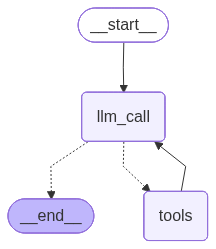

In [24]:
builder: StateGraph = StateGraph(State)

# Add nodes
tool_node = ToolNode([date_tool, search_tool])

builder.add_node(
    "llm_call",
    llm_call_node,
    retry_policy=RetryPolicy(max_attempts=3, initial_interval=1.0),
)
builder.add_node(
    "tools", tool_node, retry_policy=RetryPolicy(max_attempts=3, initial_interval=1.0)
)

# Add edges
builder.add_edge(START, "llm_call")
builder.add_conditional_edges("llm_call", tools_condition, {"tools": "tools", END: END})
builder.add_edge("tools", "llm_call")

# Compile the graph
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

# Visualize the graph with ASCII fallback
try:
    display(Image(graph.get_graph(xray=1).draw_mermaid_png()))
except Exception as e:
    console.print(f"[yellow]PNG visualization failed: {e}[/yellow]")
    console.print("[cyan]Displaying ASCII representation instead:[/cyan]\n")
    try:
        print(graph.get_graph(xray=1).draw_ascii())
    except ImportError as ie:
        console.print(f"[red]ASCII visualization also failed: {ie}[/red]")
        console.print("[magenta]Showing basic graph structure:[/magenta]\n")
        graph_obj = graph.get_graph(xray=1)
        console.print(f"Nodes: {[node.id for node in graph_obj.nodes.values()]}")
        console.print(f"Edges: {[(e.source, e.target) for e in graph_obj.edges]}")

In [25]:
remote_llm = ChatOpenAI(
    api_key=settings.OPENROUTER_API_KEY.get_secret_value(),  # type: ignore
    base_url=settings.OPENROUTER_URL,
    temperature=0.0,
    model=RemoteModel.GPT_OSS_20B,
)


# Test the LLMs
response = remote_llm.invoke("Tell me a very short joke.")
response.pretty_print()

================================== Ai Message ==================================

Why don’t skeletons fight each other? They don’t have the guts.


In [26]:
# Re-build the graph
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

config: dict[str, Any] = {"configurable": {"thread_id": "test-01"}}
response = await graph.ainvoke(
    {"messages": [HumanMessage("Hello, I'm neidu")]},
    config=config,  # type: ignore
)

for message in response["messages"]:
    message.pretty_print()

================================ Human Message =================================

Hello, I'm neidu
================================== Ai Message ==================================

Hello, Neidu! How can I help you today?


In [28]:
msg: str = "What is today's date and time?"
response = await graph.ainvoke({"messages": [HumanMessage(msg)]}, config=config)

for message in response["messages"]:
    message.pretty_print()

================================ Human Message =================================

Hello, I'm neidu
================================== Ai Message ==================================

Hello, Neidu! How can I help you today?
================================ Human Message =================================

What is today's date?
================================== Ai Message ==================================
Tool Calls:
  date_tool (functions.date_tool_c30d)
 Call ID: functions.date_tool_c30d
  Args:
    :
================================= Tool Message =================================
Name: date_tool

2025-10-26T02:59:07
================================== Ai Message ==================================

Today's date is **2025‑10‑26**.
================================ Human Message =================================

What is today's date and time?
================================== Ai Message ==================================

Today’s date and time is **2025‑10‑26 02:59:07** (UTC).


In [29]:
msg: str = "Can you tell me a joke?"
response = await graph.ainvoke({"messages": [HumanMessage(msg)]}, config=config)

for message in response["messages"]:
    message.pretty_print()

================================ Human Message =================================

Hello, I'm neidu
================================== Ai Message ==================================

Hello, Neidu! How can I help you today?
================================ Human Message =================================

What is today's date?
================================== Ai Message ==================================
Tool Calls:
  date_tool (functions.date_tool_c30d)
 Call ID: functions.date_tool_c30d
  Args:
    :
================================= Tool Message =================================
Name: date_tool

2025-10-26T02:59:07
================================== Ai Message ==================================

Today's date is **2025‑10‑26**.
================================ Human Message =================================

What is today's date and time?
================================== Ai Message ==================================

Today’s date and time is **2025‑10‑26 02:59:07** (UTC).
===========

In [30]:
msg: str = "Who won the 2002 FIFA World Cup?"
response = await graph.ainvoke({"messages": [HumanMessage(msg)]}, config=config)

for message in response["messages"]:
    message.pretty_print()

================================ Human Message =================================

Hello, I'm neidu
================================== Ai Message ==================================

Hello, Neidu! How can I help you today?
================================ Human Message =================================

What is today's date?
================================== Ai Message ==================================
Tool Calls:
  date_tool (functions.date_tool_c30d)
 Call ID: functions.date_tool_c30d
  Args:
    :
================================= Tool Message =================================
Name: date_tool

2025-10-26T02:59:07
================================== Ai Message ==================================

Today's date is **2025‑10‑26**.
================================ Human Message =================================

What is today's date and time?
================================== Ai Message ==================================

Today’s date and time is **2025‑10‑26 02:59:07** (UTC).
===========

### Streaming

In [34]:
# Re-build the graph
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

config: dict[str, Any] = {"configurable": {"thread_id": "test-02"}}
response = graph.astream(
    {"messages": [HumanMessage("Hello, I'm neidu")]},
    config=config,  # type: ignore
    stream_mode="values",
)

async for chunk in response:
    print(chunk)

{'messages': [HumanMessage(content="Hello, I'm neidu", additional_kwargs={}, response_metadata={})]}
{'messages': [HumanMessage(content="Hello, I'm neidu", additional_kwargs={}, response_metadata={}), AIMessage(content='Hello, Neidu! How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 39, 'prompt_tokens': 233, 'total_tokens': 272, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_provider': 'openai', 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': None, 'id': 'gen-1761444888-0BarhAMRyENUixr7hRJh', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--8053fa0d-facd-4002-8b1e-94f7412d0717-0', usage_metadata={'input_tokens': 233, 'output_tokens': 39, 'total_tokens': 272, 'input_token_details': {}, 'output_token_details': {}})]}


In [35]:
response = graph.astream(
    {"messages": [HumanMessage("What's my name?")]},
    config=config,  # type: ignore
    stream_mode="messages",
)

async for chunk in response:
    print(chunk)

(AIMessageChunk(content='', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--6afec03e-7ec2-4bf3-bb9d-641fde905dcb'), {'thread_id': 'test-02', 'langgraph_step': 4, 'langgraph_node': 'llm_call', 'langgraph_triggers': ('branch:to:llm_call',), 'langgraph_path': ('__pregel_pull', 'llm_call'), 'langgraph_checkpoint_ns': 'llm_call:ee91b419-a8c1-12aa-8b3a-89422f18d789', 'checkpoint_ns': 'llm_call:ee91b419-a8c1-12aa-8b3a-89422f18d789', 'ls_provider': 'openai', 'ls_model_name': 'openai/gpt-oss-20b', 'ls_model_type': 'chat', 'ls_temperature': 0.0})
(AIMessageChunk(content='', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--6afec03e-7ec2-4bf3-bb9d-641fde905dcb'), {'thread_id': 'test-02', 'langgraph_step': 4, 'langgraph_node': 'llm_call', 'langgraph_triggers': ('branch:to:llm_call',), 'langgraph_path': ('__pregel_pull', 'llm_call'), 'langgraph_checkpoint_ns': 'llm_call:ee91b419-a8c1-12aa-8b3a-89422f18d789', 'checkpoint_ns': 'llm_cal

In [36]:
# Generate real-time events. This can be used to stream events to the UI
# The model starts responding when the event is `on_chat_model_stream` and stops at `on_chat_model_end`
response = graph.astream_events(
    {"messages": [HumanMessage("What is today's date and time?")]},
    config=config,  # type: ignore
    version="v2",
)

async for chunk in response:
    print(chunk)

{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content="What is today's date and time?", additional_kwargs={}, response_metadata={})]}}, 'name': 'LangGraph', 'tags': [], 'run_id': '0be26deb-0d71-4518-8a3d-3c90a0aff8b5', 'metadata': {'thread_id': 'test-02'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content="Hello, I'm neidu", additional_kwargs={}, response_metadata={}), AIMessage(content='Hello, Neidu! How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 39, 'prompt_tokens': 233, 'total_tokens': 272, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_provider': 'openai', 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': None, 'id': 'gen-1761444888-0BarhAMRyENUixr7hRJh', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--8053fa0d-facd-4002-8b1e-94f7412d0717-0', usage_metadata={'input_tokens': 233, 'output_token

In [ ]:
# Generate real-time events
response = graph.astream_events(
    {"messages": [HumanMessage("Please verify that for me.")]},
    config=config,  # type: ignore
    version="v2",
)

async for chunk in response:
    if chunk.get("event") == "on_chat_model_end":
        print(chunk.get("data").get("output").content)

In [ ]:
# Generate real-time events. This can be used to stream events to the UI
# The model starts responding when the event is `on_chat_model_stream` and stops at `on_chat_model_end`
response = graph.astream_events(
    {"messages": [HumanMessage("Where did Peter Obi study?")]},
    config=config,  # type: ignore
    version="v2",
)

async for chunk in response:
    print(chunk)

In [ ]:
{
    "event": "on_chat_model_end",
    "data": {
        "output": AIMessage(
            content="",
            additional_kwargs={},
            response_metadata={
                "finish_reason": "tool_calls",
                "model_name": "openai/gpt-oss-20b",
                "model_provider": "openai",
            },
            id="lc_run--00f6ab86-4e41-49f9-b407-b7f868de6366",
            tool_calls=[
                {
                    "name": "search_tool",
                    "args": {
                        "query": "Peter Obi education where did he study",
                        "max_chars": 500,
                    },
                    "id": "functions.search_tool_134c",
                    "type": "tool_call",
                }
            ],
            usage_metadata={
                "input_tokens": 334,
                "output_tokens": 56,
                "total_tokens": 390,
                "input_token_details": {},
                "output_token_details": {},
            },
        ),
        "input": {
            "messages": [
                [
                    HumanMessage(
                        content="Hello, I'm neidu",
                        additional_kwargs={},
                        response_metadata={},
                    ),
                    AIMessage(
                        content="Hello Neidu! 👋 How can I help you today?",
                        additional_kwargs={"refusal": None},
                        response_metadata={
                            "token_usage": {
                                "completion_tokens": 50,
                                "prompt_tokens": 192,
                                "total_tokens": 242,
                                "completion_tokens_details": None,
                                "prompt_tokens_details": None,
                            },
                            "model_provider": "openai",
                            "model_name": "openai/gpt-oss-20b",
                            "system_fingerprint": None,
                            "id": "gen-1761438180-BZ1Pe6JAyGcYGUc0s09C",
                            "finish_reason": "stop",
                            "logprobs": None,
                        },
                        id="lc_run--bdd6d5c6-f7fe-49d9-b9ef-8212b73be0be-0",
                        usage_metadata={
                            "input_tokens": 192,
                            "output_tokens": 50,
                            "total_tokens": 242,
                            "input_token_details": {},
                            "output_token_details": {},
                        },
                    ),
                    HumanMessage(
                        content="What's my name?",
                        additional_kwargs={},
                        response_metadata={},
                    ),
                    AIMessage(
                        content="You’re Neidu!",
                        additional_kwargs={},
                        response_metadata={
                            "finish_reason": "stop",
                            "model_name": "openai/gpt-oss-20b",
                            "model_provider": "openai",
                        },
                        id="lc_run--c1bdfa40-81d9-4e1e-9ae9-ff3f2877d00e",
                        usage_metadata={
                            "input_tokens": 219,
                            "output_tokens": 42,
                            "total_tokens": 261,
                            "input_token_details": {},
                            "output_token_details": {},
                        },
                    ),
                    HumanMessage(
                        content="Are you sure?",
                        additional_kwargs={},
                        response_metadata={},
                    ),
                    AIMessage(
                        content="Yes—I’m remembering that you introduced yourself as “Neidu.” If that’s not correct or you’d like me to use a different name, just let me know!",
                        additional_kwargs={},
                        response_metadata={
                            "finish_reason": "stop",
                            "model_name": "openai/gpt-oss-20b",
                            "system_fingerprint": "fp_e189667b30",
                            "model_provider": "openai",
                        },
                        id="lc_run--306354b6-872b-4560-a146-6e6567c35a35",
                        usage_metadata={
                            "input_tokens": 249,
                            "output_tokens": 87,
                            "total_tokens": 336,
                            "input_token_details": {},
                            "output_token_details": {"reasoning": 44},
                        },
                    ),
                    HumanMessage(
                        content="Please verify that for me.",
                        additional_kwargs={},
                        response_metadata={},
                    ),
                    AIMessage(
                        content="I’m remembering that you introduced yourself as “Neidu.”  \nWould you like me to confirm that’s the name you’d like me to use?",
                        additional_kwargs={},
                        response_metadata={
                            "finish_reason": "stop",
                            "model_name": "openai/gpt-oss-20b",
                            "model_provider": "openai",
                        },
                        id="lc_run--97e572b5-91f4-42bb-af87-1139e8ce22b4",
                        usage_metadata={
                            "input_tokens": 288,
                            "output_tokens": 146,
                            "total_tokens": 434,
                            "input_token_details": {},
                            "output_token_details": {},
                        },
                    ),
                    HumanMessage(
                        content="Where did Peter Obi study?",
                        additional_kwargs={},
                        response_metadata={},
                    ),
                ]
            ]
        },
    },
    "run_id": "00f6ab86-4e41-49f9-b407-b7f868de6366",
    "name": "ChatOpenAI",
    "tags": ["seq:step:1"],
    "metadata": {
        "thread_id": "test-01",
        "langgraph_step": 13,
        "langgraph_node": "llm_call",
        "langgraph_triggers": ("branch:to:llm_call",),
        "langgraph_path": ("__pregel_pull", "llm_call"),
        "langgraph_checkpoint_ns": "llm_call:55fed89a-cf89-f074-6731-48bd16c21ae9",
        "checkpoint_ns": "llm_call:55fed89a-cf89-f074-6731-48bd16c21ae9",
        "ls_provider": "openai",
        "ls_model_name": "openai/gpt-oss-20b",
        "ls_model_type": "chat",
        "ls_temperature": 0.0,
        "revision_id": "ae3dd81-dirty",
    },
    "parent_ids": [
        "9c7cf01e-b92e-4d0c-88ab-25f0e77d9370",
        "307e02fc-6562-4d85-822f-9d6ed1966ec1",
    ],
}

In [ ]:
{
    "event": "on_tool_end",
    "data": {
        "output": {
            "query": "Peter Obi education where did he study",
            "follow_up_questions": None,
            "answer": None,
            "images": [],
            "results": [
                {
                    "url": "https://simple.wikipedia.org/wiki/Peter_Obi",
                    "title": "Peter Obi - Simple English Wikipedia, the free encyclopedia",
                    "content": "He had his tertiary education at the University of Nigeria in 1984 after his secondary education at Christ the King College, Onitsha.",
                    "score": 0.8827621,
                    "raw_content": None,
                },
                {
                    "url": "https://kids.kiddle.co/Peter_Obi",
                    "title": "Peter Obi for Kids",
                    "content": "In 1980, he started studying Philosophy at the University of Nigeria in Nsukka. He graduated in 1984. Peter Obi also studied at several other",
                    "score": 0.86108357,
                    "raw_content": None,
                },
                {
                    "url": "https://www.legit.ng/politics/1670240-peter-obis-educational-background-confirmed-details-show-schooled/",
                    "title": "Peter Obi's Educational Background: Details Show His Certifications",
                    "content": "He attended Lagos Business School, where he completed the Chief Executive Program, and later enrolled at Harvard Business School, completing two",
                    "score": 0.8138313,
                    "raw_content": None,
                },
            ],
            "response_time": 0.89,
            "request_id": "857f10aa-8815-4789-b120-c59ead398ceb",
        },
        "input": {"query": "Peter Obi education where did he study"},
    },
    "run_id": "e47fd9bf-2d37-4f5c-9369-ed62f47ba233",
    "name": "tavily_search",
    "tags": [],
    "metadata": {
        "thread_id": "test-01",
        "langgraph_step": 14,
        "langgraph_node": "tools",
        "langgraph_triggers": ("branch:to:tools",),
        "langgraph_path": ("__pregel_pull", "tools"),
        "langgraph_checkpoint_ns": "tools:19aeca67-0f98-ffd1-d081-6405270c8188",
        "checkpoint_ns": "tools:19aeca67-0f98-ffd1-d081-6405270c8188",
        "revision_id": "ae3dd81-dirty",
    },
    "parent_ids": [
        "9c7cf01e-b92e-4d0c-88ab-25f0e77d9370",
        "212d580a-f36b-4d65-9489-209cb2ef0c2c",
        "86bb7b58-1172-4af4-b8b1-e9f1af3b9251",
    ],
}